<a href="https://colab.research.google.com/github/PacoElizondo/ComputerVisionUPT/blob/main/Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load and visualize the 'coins' image from the skimage built-in datasets. Report the size of the image and range of the pixel grayscale levels.

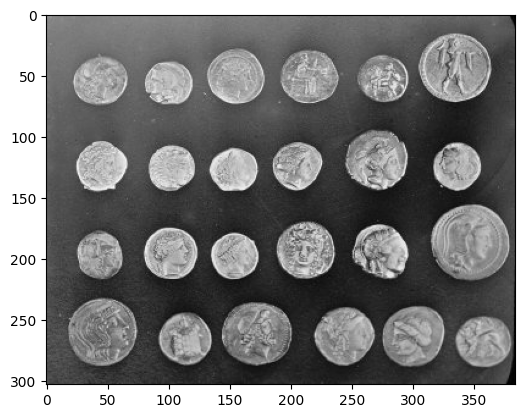

The size of the image is:  (303, 384)
The range of the pixel grayscale levels is: [ 1 , 252 ]


<Figure size 640x480 with 0 Axes>

In [14]:
import skimage as sk
import matplotlib.pyplot as plt

coins_img = sk.data.coins()
plt.imshow(coins_img, cmap='gray')
plt.show()
print('The size of the image is: ',coins_img.shape)

fig = plt.figure()
img_array = coins_img.flatten()

print('The range of the pixel grayscale levels is: [', img_array.min(), ',', img_array.max(), ']')

# intensity levels


## 2. Represent the histogram of the image. Explain the peaks of the histogram in terms of regions of the image.

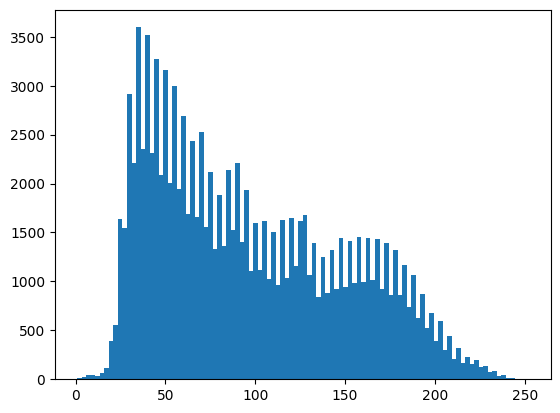

In [16]:
import numpy as np
n = plt.hist(img_array, bins = 100, range = [1, img_array.max()])

The histogram represents accurately that there are more dark pixels than bright ones; the area sorrounding the coins. Around the values of 150-180 there is another peak, this corresponds to the similar brightness of the coins.

## 3. Apply noise to the image and use the correct function to erase the noise.

<Figure size 640x480 with 0 Axes>

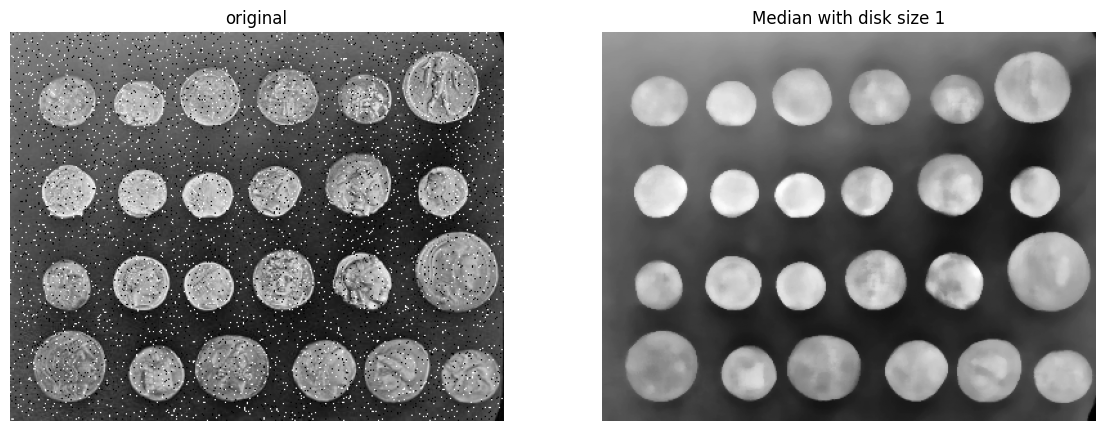

In [113]:
speckled_coins = sk.util.random_noise(coins_img, mode='s&p')
fig = plt.figure()
# plt.imshow(speckled_coins, cmap='gray')

from skimage.filters.rank import mean_bilateral, median
from skimage.morphology import disk

img = sk.img_as_ubyte(speckled_coins)

img_filtered = median(img, disk(5))

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

plot_comparison(img, img_filtered, 'Median with disk size 1')

## 4. Segment the image using a k-means clustering algorithm with k=2 and represent the result

Text(0.5, 1.0, 'k_means')

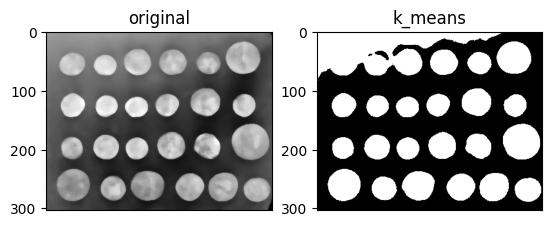

In [114]:
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans

v_img = np.reshape(img_filtered,(img_filtered.shape[0]*img_filtered.shape[1],1))
n_clus = 2
kmeans = KMeans(n_clus, random_state=0).fit(v_img)
v_kmeans = kmeans.predict(v_img)
img_kmeans = np.reshape(v_kmeans,(img_filtered.shape[0],img_filtered.shape[1]))

fig = plt.figure()
plt.subplot(1, 2, 1), plt.xticks([]), plt.xticks([])
plt.imshow(img_filtered, cmap='gray')
plt.title('original')
plt.subplot(1, 2, 2),  plt.xticks([]), plt.xticks([])
plt.imshow(img_kmeans, cmap='gray')
plt.title('k_means')

## 5. Label the objects found in the image. Generate a figure with the original image and the labeled image. How many coins are there in the image?

The k_means segmentation (and otsu, already tried) does not accurately separate the image, so i'll set up a fixed threshold.

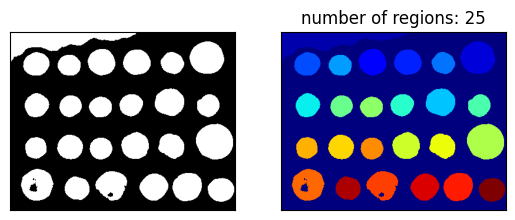

In [156]:
thresh = 115
segmented_image = img_filtered > thresh
fig = plt.figure()
plt.subplot(1, 2, 1) ,  plt.xticks([]), plt.yticks([])
plt.imshow(segmented_image, cmap='gray')

label_image, nregions = sk.measure.label(segmented_image,return_num=True)
plt.subplot(1, 2, 2),  plt.xticks([]), plt.yticks([])
plt.imshow(label_image, cmap='jet')
plt.title('number of regions: ' + str(nregions))
plt.show()





To "filter" out the false positive on the top corner we consider the eccentricity:

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


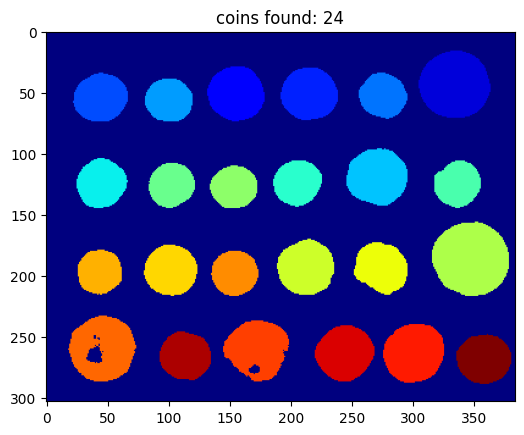

In [168]:
import pandas as pd

props = sk.measure.regionprops_table(label_image, properties=['label','eccentricity',
                                                              'area', 'axis_major_length',
                                                              'orientation'])
df_features = pd.DataFrame(props)
df_features.head()
n_coins = np.array( (df_features.eccentricity <= 0.9)) # if the shape is not round its not considered
indices = np.where(n_coins)[0]
print(indices)


valid_coins = df_features['label'][n_coins].to_numpy()
coin_mask = (label_image == valid_coins[0])
for i in valid_coins:
  coin_mask |= (label_image == i)
true_coins = label_image * coin_mask
fig = plt.figure()
plt.imshow(true_coins, cmap='jet')
plt.title('coins found: ' + str(indices.size))
plt.show()

## 6. Extract the area, major axis length and orientation of each coin. Report the average values of the extracted features. Represent a scatterplot of the area vs major axis length.


45.650955887608944
-0.24579058402597206


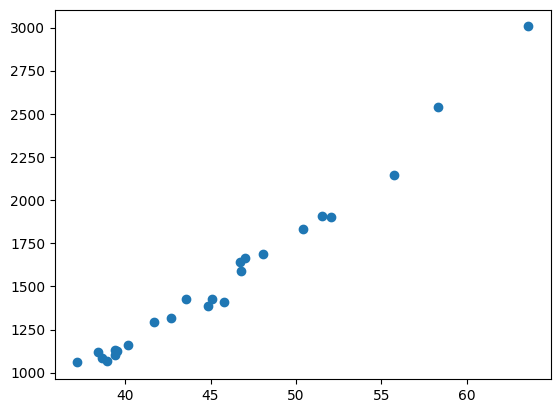

In [173]:
axis_major = df_features['axis_major_length'][n_coins].to_numpy()
print(axis_major.mean())

orientation = df_features['orientation'][n_coins].to_numpy()
print(orientation.mean())

area = df_features['area'][n_coins].to_numpy()

fig = plt.figure()
plt.scatter(x=axis_major, y=area)